# Twitter Hate Speech Analysis

According to data acquired from the Federal Bureau of Intelligence (FBI) and Geneva International Center for Justice, hate speech and hate crimes have both been on the rise for the past few years. Studies documented on how to combat hateful idealogies are complicated and offer no easy answers. Further complicating the issue is that hate speech affects different groups differently and rises and drops on who it targets over the years. Since recent times have shown such a large surge in hateful idealogies, this project hopes to analyze current hate speech trends using Natural Language Processing (NLP), Data Analysis, and Machine Learning.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load Up Datasets

In [2]:
df_train = pd.read_csv('Modeling/Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Modeling/Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Modeling/Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Modeling/Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Modeling/Data/hate_speech_training_5.csv')

### Clean Up Datasets and Map Hate Speech to 1 and Non Hate Speech to 0

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

### Combine the 5 Training Sets Together

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Initial Exploratory Analysis

### How Many Hate Tweets Do We Have vs. Non Hate Tweets?

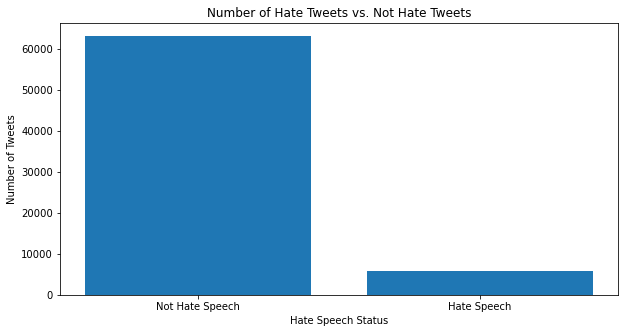

In [9]:
fig_1, ax_1 = plt.subplots(figsize = (10,5))

x = ['Not Hate Speech', 'Hate Speech']
y = df['label'].value_counts().values

ax_1.bar(x, y)
ax_1.set_title('Number of Hate Tweets vs. Not Hate Tweets')
ax_1.set_xlabel('Hate Speech Status')
ax_1.set_ylabel('Number of Tweets');

### Word Cloud for Labeled Hate Tweets

#### *WARNING! This Word Cloud Will Inevitable Contain Hateful and Offensive Language (including slurs for different protected classes). Please do not run these cells if you are unable to view that kind of language currently for any reason*

In [10]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [11]:
comment_words = ''
stopwords = list(STOPWORDS)
for word in df[df['label'] == 1]['tweet']:
    tokens = word.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

In [12]:
stopwords.append('user')
stopwords.append('t')
stopwords.append('co')
stopwords.append('amp')

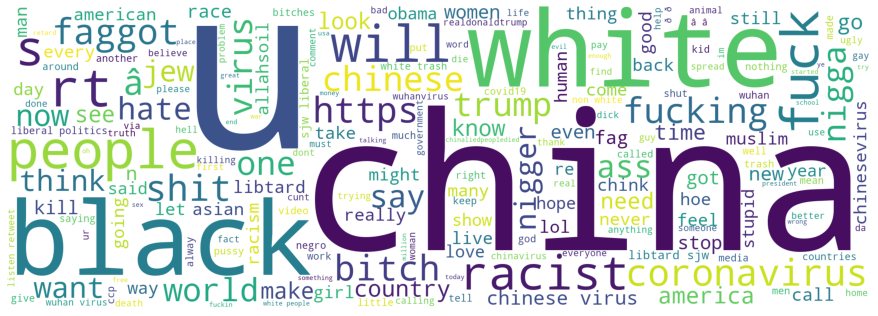

In [13]:
wordcloud = WordCloud(width = 2000, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

#### Unsurprisingly, China is one of the biggest terms which logically follows due to the current rise in Asian hate speech

### Is There A Difference In Statistically Significant Difference Between The Length Of Hate Tweets vs Not Hate Tweets?

In [14]:
df_len = df
df_len['length'] = df_len['tweet'].apply(len) #Add a columns for the length of tweets

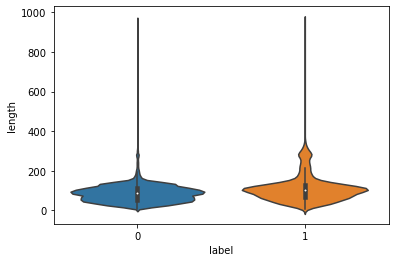

In [15]:
sns.violinplot(x = 'label', y = 'length', data = df_len); #1 = Hate Speech, #0 = Not Hate Speech

### These violin plots are useful but don't clearly reflect whether the two groups are statistically significantly different or not. Let's run a two sample T-Test with an alpha of 0.05

In [16]:
from scipy import stats
stats.ttest_ind(df_len[df_len['label'] == 1]['length'], df_len[df_len['label'] == 0]['length'])

Ttest_indResult(statistic=39.29300040893459, pvalue=0.0)

The p-value is less then your average alpha of 0.05 which means there is a statistically significant difference between the two groups. The violin plots show that hate tweets (on average) are longer then not hate tweets

### Let's See The Distribution & Mean of Tweet Characters For Hate Speech & Not Hate Speech

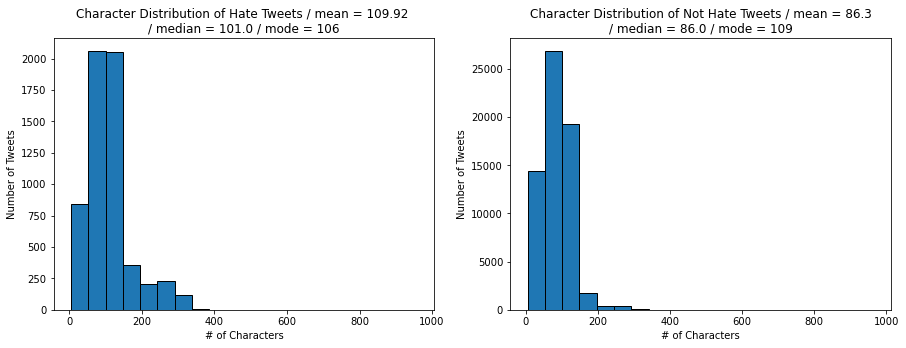

In [17]:
from statistics import mode

fig_2, ax_2 = plt.subplots(figsize = (15, 5), ncols = 2)

x_hate = df_len[df_len['label'] == 1]['length']
x_not_hate = df_len[df_len['label'] == 0]['length']

ax_2[0].hist(x_hate, bins = 20, edgecolor = 'black')
ax_2[0].set_title(f"""Character Distribution of Hate Tweets / mean = {round(np.mean(x_hate), 2)} 
/ median = {round(np.median(x_hate), 2)} / mode = {round(mode(x_hate), 2)}""")
ax_2[0].set_xlabel('# of Characters')
ax_2[0].set_ylabel('Number of Tweets')

ax_2[1].hist(x_not_hate, bins = 20, edgecolor = 'black')
ax_2[1].set_title(f"""Character Distribution of Not Hate Tweets / mean = {round(np.mean(x_not_hate), 2)}
/ median = {round(np.median(x_not_hate), 2)} / mode = {round(mode(x_not_hate), 2)}""");
ax_2[1].set_xlabel('# of Characters')
ax_2[1].set_ylabel('Number of Tweets');

It seems that on average, hate tweets are about 24 characters longer then non-hate tweets

#### Let's take a look at word frequency for hate tweets, not hate tweets, and all tweets to see if there are any discernible patterns before modeling

### Word Frequency Chart for All Tweets

In [18]:
import nltk
import string
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [19]:
sw = stopwords.words('english')

In [20]:
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 'http', 'RT', '#','##','####','######','##########','##@user']

In [21]:
sw = sw + sw_add

In [22]:
word_list = []
reg_token = RegexpTokenizer("([@#a-zA-Z]+(?:'[a-z]+)?)")
for tweet in df['tweet'].values:
    words = reg_token.tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    for word in words:
        word_list.append(lemmatizer.lemmatize(word))

In [23]:
word_list = [word for word in word_list if word not in sw]

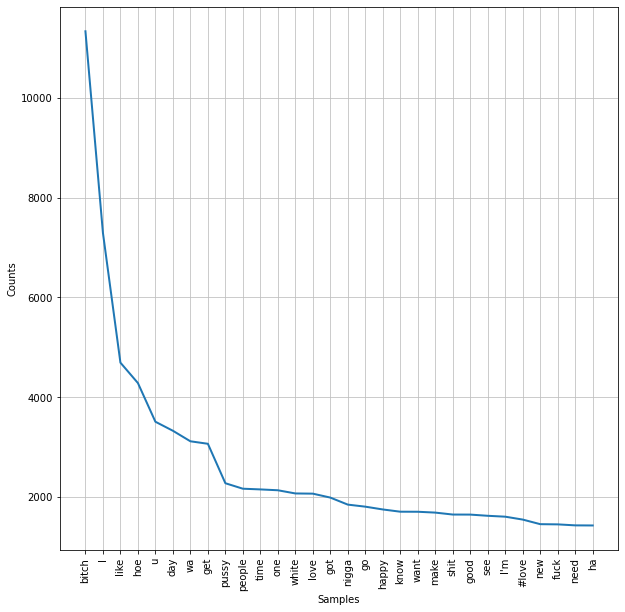

In [24]:
fdist = FreqDist(word_list)
plt.figure(figsize=(10, 10))
fdist.plot(30);

We can actually see a fair amount of offensive language on here that could potentially be present in hate tweets but not necessarily given the proper context ('bitch' for example can be used both in offensive and friendly terms depending on speaker and receiver). This will complicate things for our model

### Word Frequency Chart for Hate Tweets

In [31]:
hate_word_list = []
for tweet in df[df['label'] == 1]['tweet'].values:
    words = reg_token.tokenize(tweet)
    lemmatizer_2 = WordNetLemmatizer()
    for word in words:
        hate_word_list.append(lemmatizer_2.lemmatize(word))

In [32]:
hate_word_list = [word for word in hate_word_list if word not in sw]

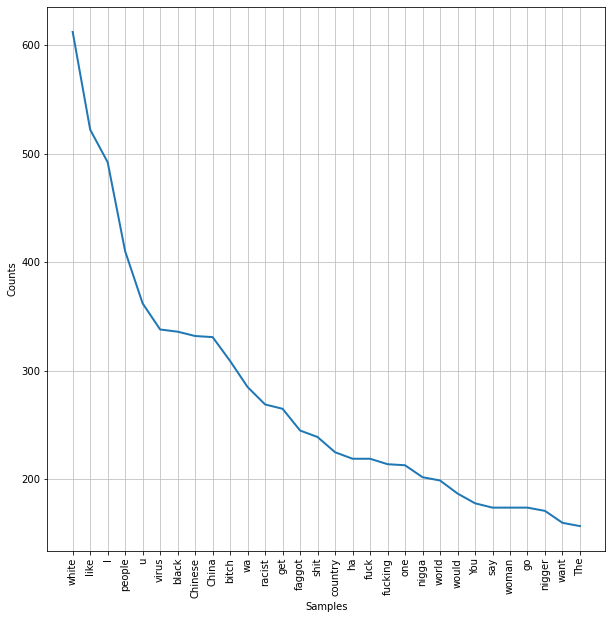

In [33]:
fdist_2 = FreqDist(hate_word_list)
plt.figure(figsize=(10, 10))
fdist_2.plot(30);

Suprisingly less offensive terms BUT more specific terms such as China and virus. Given the rise we've seen in anti-Asian hate, this is unsurprising

## Word Frquency Chart for Not Hate Tweets

In [34]:
not_hate_word_list = []
for tweet in df[df['label'] == 0]['tweet'].values:
    words = reg_token.tokenize(tweet)
    lemmatizer_3 = WordNetLemmatizer()
    for word in words:
        not_hate_word_list.append(lemmatizer_3.lemmatize(word))

In [35]:
not_hate_word_list = [word for word in not_hate_word_list if word not in sw]

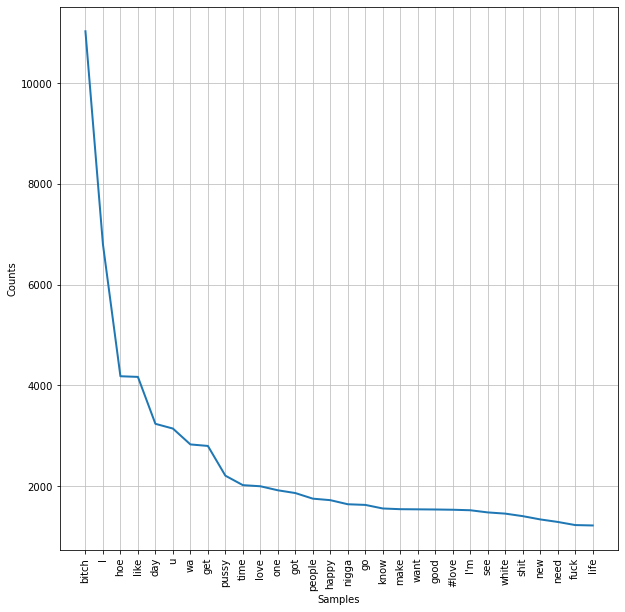

In [36]:
fdist_3 = FreqDist(not_hate_word_list)
plt.figure(figsize=(10, 10))
fdist_3.plot(30);

Pretty similar to the all tweets list and potentially a very complicated issue for our model. Let's get started on modeling

#### That's really it for basic EDA Analysis of our dataset, the next cell will show our NLP and modeling results. Grid searches were a big part of that process so the actual modeling and grid searches will take place on separate notebooks but you can see the results below

## Modeling Results

### Simple Dummy Model (Picks The Majority Class Each Time):

- Training Overall Accuracy: 91.49%
- Cross-Validation Scores: 91.49%, 91.50%, 91.50%, 91.50%, 91.50%
- Testing Overall Accuracy: 91.50%
- AUC for ROC Curve: 0.50
- precision for not hate speech: 91%
- precision for hate speech: 0%
- recall for not hate speech: 100%
- recall for hate speech: 0%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 0%

Overall Conclusion on this model: The class imbalance will pose a problem that we won't be able to use accuracy as a metric. The simple model shows that if you just pick "Not Hate Speech" every single time, the model will still be reflected as about 91.5% accuracy. This means the most important metric for this project will be precision for Hate Speech as priority #1 and then recall for Hate Speech as priority #2.

### Best Multinomial Model with TF-IDF:
#### This model's regex statement performed better when hashtags and mentions were kept alongside the words. Removing hashtags and mentions, slightly bumped up recall but took a big sacrifice on precision

- Training Overall Accuracy: 94.72%
- Cross-Validation Scores: 92.49%, 92.57%, 92.94%, 92.55%, 92.34% 
- Testing Overall Accuracy: 92.89%
- AUC for ROC Curve: 0.89
- precision for not hate speech: 93%
- precision for hate speech: 77%
- recall for not hate speech: 99%
- recall for hate speech: 23%
- f1-score for not hate speech: 96%
- f1-score for hate speech: 36%

Overall Conclusion on this model: Significant precision on hate speech but the recall is not particularly great

### Best Multinomial Bayes Model with Count Vectorizer:
#### Both regex statements performed nearly equally well in this context. In this case, we'll go with the one that included hashtags and mentions for the slight bump in hate speech precision

- Training Overall Accuracy: 97.98%
- Cross-Validation Scores: 92.75% , 93.21%, 93.06%, 93.29%, 93.08%
- Testing Overall Accuracy: 93.54%
- AUC for ROC Curve: 0.82
- precision for not hate speech: 95%
- precision for hate speech: 73%
- recall for not hate speech: 99%
- recall for hate speech: 38%
- f1-score for not hate speech: 97%
- f1-score for hate speech: 50%

Overall Conclusion on this model: Lost some precision since the other Multinomial Bayes model but still significant. Significantly better recall. Decently performing models on hate speech.

## Best Logistic Regression Model with TF-IDF:
#### This model performed best when allowed to take # and mentions (@) into account (big bump in precision but at the expense of a chunk of recall)

- Training Overall Accuracy: 96.02%
- Cross-Validation Scores: 92.12%, 92.09%, 92.33%, 92.17%, 92.07%
- Testing Overall Accuracy: 92.35%
- AUC for ROC Curve: 0.80
- precision for not hate speech: 93%
- precision for hate speech: 62%
- recall for not hate speech: 99%
- recall for hate speech: 25%
- f1-score for not hate speech: 96% 
- f1-score for hate speech: 36%

Overall Conclusion on this model: The precision isn't bad (recall is not great but this seems to be a similar theme across these models) but we have other models that do better

## Best Logistic Regression with Count Vectorizer:
#### This model performed better when regex statement only took words and did not include hashtags or mentions

- Training Overall Accuracy: 92.09%
- Cross-Validation Scores: 92.06%, 92%, 91.91%, 92.04%, 92.05%
- Testing Overall Accuracy: 91.97%
- AUC for ROC Curve: 0.70
- precision for not hate speech: 92% 
- precision for hate speech: 70%
- recall for not hate speech: 100%
- recall for hate speech: 10%
- f1-score for not hate speech: 96% 
- f1-score for hate speech: 17%

Overall Conclusion on this model: Precision is much better but the recall is really bad which really doesn't make this model worth it

## Best Decision Tree Model with TF-IDF
#### This model actually performed best when the regex statement removed hashtags and mentions and only took out the words in the tweet

- Training Overall Accuracy: 92.03%
- Cross-Validation Scores: 92.00%, 91.97%, 91.82%, 91.93%, 92.06%
- Testing Overall Accuracy: 91.95%
- AUC for ROC Curve: 0.54
- precision for not hate speech: 92%
- precision for hate speech: 76%
- recall for not hate speech: 100%
- recall for hate speech: 8%
- f1-score for not hate speech: 96% 
- f1-score for hate speech: 14%

Overall Conclusion on this model: Pretty bad at detecting hate speech. Even using SMOTE, it predicted hate speech so few times that the area under the curve for the ROC curve is nearly 0.5

## Best Decision Tree Model with Count Vectorizer
#### This model actually performed best when the regex statement removed hashtags and mentions and only took out the words in the tweet

- Training Overall Accuracy: 92.04%
- Cross-Validation Scores: 91.97%, 91.91% , 91.79%, 91.87%, 91.97%
- Testing Overall Accuracy: 91.94%
- AUC for ROC Curve: 0.54
- precision for not hate speech: 92%
- precision for hate speech: 78%
- recall for not hate speech: 100%
- recall for hate speech: 7%
- f1-score for not hate speech: 96% 
- f1-score for hate speech: 13%

Overall Conclusion on this model: Suffers the same issues as the other Decision Tree model. Just not a good model for detecting hate speech

## Best Support Vector Classifier with TF-IDF
#### This model takes an incredibly long time to perform and did not lend itself well to a grid search so only a few models could be tested but from those few, the TF-IDF performed best when regex statement included hashtags and mentions and when SMOTE balanced the classes at 50/50

- Training Overall Accuracy: 99.52%
- Cross-Validation Scores: *Unable to do cross-validation as the model took hours just to fit a single model*
- Testing Overall Accuracy: 93.78%
- AUC for ROC Curve: 0.92
- precision for not hate speech: 94%
- precision for hate speech: 85%
- recall for not hate speech: 99%
- recall for hate speech: 33%
- f1-score for not hate speech: 97% 
- f1-score for hate speech: 47%

Overall Conclusion on this model: Spoiler alert. For hate speech precision, this seems to be our best model. It is the only model with hate speech precision in the high 80s with a recall that is not in the single digits. In this case, it seems impossible to have both high precision and recall but this model seems to do the best out of all the others

## Best Support Vector Classifer with Count Vectorizer
#### This model takes an incredibly long time to perform and did not lend itself well to a grid search so only a few models could be tested but from those few, the TF-IDF performed best when regex statement included hashtags and mentions and when SMOTE balanced the classes at 75/25 (minority class / majority class, respectively)

- Training Overall Accuracy: 95.71%
- Cross-Validation Scores: *Unable to do cross-validation as the model took hours just to fit a single model*
- Testing Overall Accuracy: 90%
- AUC for ROC Curve: 0.81
- precision for not hate speech: 94%
- precision for hate speech: 39%
- recall for not hate speech: 95%
- recall for hate speech: 32%
- f1-score for not hate speech: 95% 
- f1-score for hate speech: 35%

Overall Conclusion on this model: Significantly worst. The problem with this model is that it predicts so many tweets to be hate tweets that precision just takes a massive nose dive and recall ends up not improving

## Best ADA Boosting Model with TF-IDF 
#### This model performs best when regex statment is able to take # and @ into account

- Training Overall Accuracy: 88.69%
- Cross-Validation Scores: *Unable to do cross-validation as the model took hours just to fit a single model*
- Testing Overall Accuracy: 89.30%
- AUC for ROC Curve: 0.81
- precision for not hate speech: 95%
- precision for hate speech: 40%
- recall for not hate speech: 93%
- recall for hate speech: 53%
- f1-score for not hate speech: 94%  
- f1-score for hate speech: 46%

Overall Conclusion on this model: Relatively low precision and recall. Bad at predicting hate speech

## Best ADA Boosting Model with Count Vectorizer
#### This model performed equally well with both regex statement but 50/50 class balanced outweighted greater oversampling

- Training Overall Accuracy: 65.68%
- Cross-Validation Scores: *Unable to do cross-validation as the model took hours just to fit a single model*
- Testing Overall Accuracy: 65.44%
- AUC for ROC Curve: 0.74
- precision for not hate speech: 96%
- precision for hate speech: 16%
- recall for not hate speech: 65%
- recall for hate speech: 70%
- f1-score for not hate speech: 77%  
- f1-score for hate speech: 26%

Overall Conclusion on this model: Really good recall but at the expense of very low precision. We won't be using this model

## Best Gradient Boosting Model with TF-IDF
#### The model performed best when allowed to take # and @ into account

- Training Overall Accuracy: 89.21%
- Cross-Validation Scores: *Unable to do cross-validation as the model took hours just to fit a single model*
- Testing Overall Accuracy: 89.50%
- AUC for ROC Curve: 0.80
- precision for not hate speech: 93%
- precision for hate speech: 53%
- recall for not hate speech: 98%
- recall for hate speech: 24%
- f1-score for not hate speech: 96%  
- f1-score for hate speech: 36%

Overall Conclusion on this model: Not a particularly great model. Most of our other models performed better

## Best Gradient Boosting Model with Count Vectorizer
#### This model performed best when only words were taken into account

- Training Overall Accuracy: 74.23%
- Cross-Validation Scores: *Unable to do cross-validation as the model took hours just to fit a single model*
- Testing Overall Accuracy: 74.50%
- AUC for ROC Curve: 0.77
- precision for not hate speech: 96%  
- precision for hate speech: 19%
- recall for not hate speech: 76%
- recall for hate speech: 63%
- f1-score for not hate speech: 84%   
- f1-score for hate speech: 30%

Overall Conclusion on this model: Great recall but at the expense of precision. Not good for our needs

## Best XGBoost Model with TF-IDF
#### This model performed best when allowed to take hashtags and mentions into account

- Training Overall Accuracy: 93.23%
- Cross-Validation Scores: 92.28%, 0.92.13%, 92.10%, 92.48%, 92.05%
- Testing Overall Accuracy: 92.43%
- AUC for ROC Curve: 0.63
- precision for not hate speech: 93%   
- precision for hate speech: 73%
- recall for not hate speech: 99%
- recall for hate speech: 17%
- f1-score for not hate speech: 96%    
- f1-score for hate speech: 28%

Overall Conclusion on this model: Decent hate speech precision, recall is not great. We have quite a few models that do a lot better

## Best XGBoost Model with Count Vectorizer
#### This model performed best when only taking words into account

- Training Overall Accuracy: 92.74%
- Cross-Validation Scores: 92.65%, 92.28%, 92.44%, 92.51%, 92.63%
- Testing Overall Accuracy: 92.78%
- AUC for ROC Curve: 0.84
- precision for not hate speech: 94%  
- precision for hate speech: 69%
- recall for not hate speech: 99%
- recall for hate speech: 28%
- f1-score for not hate speech: 96%     
- f1-score for hate speech: 40%

Overall Conclusion on this model: Poor recall. Precision is barely passable. We have plenty of better models